<a href="https://colab.research.google.com/github/Nitharshana-R/Comment-Toxicity/blob/main/Comment_Toxicity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm



In [10]:
df2= pd.read_csv('/content/youtoxic_english_1000.csv')

In [13]:
df2.head()


,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False


In [15]:
df2['Toxic'] = df2.iloc[:, 3:].any(axis=1)
df2_processed = df2[['Text', 'Toxic']]




In [16]:
print(df2_processed.head())

                                                Text  Toxic
0  If only people would just take a step back and...  False
1  Law enforcement is not trained to shoot to app...   True
2  \nDont you reckon them 'black lives matter' ba...   True
3  There are a very large number of people who do...  False
4  The Arab dude is absolutely right, he should h...  False


In [17]:
df2_processed.describe()

,Text,Toxic
count,1000,1000
unique,997,2
top,run them over,False
freq,3,538


In [18]:
print(df2_processed.dtypes)
print(df2_processed.isnull().sum())

Text     object
Toxic      bool
dtype: object
Text     0
Toxic    0
dtype: int64


In [19]:
duplicate_rows = df2_processed[df2_processed.duplicated(subset=['Text'], keep=False)]
print("Duplicate rows based on 'Text' column:")
print(duplicate_rows)

# Drop duplicate comments
df2_processed.drop_duplicates(subset=['Text'], keep='first', inplace=True)

# Confirm duplicates are removed
print("Number of rows after removing duplicates:", len(df2_processed))

# Reindex the DataFrame after dropping duplicates
df2_processed.reset_index(drop=True, inplace=True)

Duplicate rows based on 'Text' column:
              Text  Toxic
592  RUN THEM OVER   True
642  run them over   True
657  run them over   True
677  run them over   True
699  RUN THEM OVER   True
Number of rows after removing duplicates: 997


<ipython-input-19-4058efeba7ce>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_processed.drop_duplicates(subset=['Text'], keep='first', inplace=True)


In [20]:
toxic_distribution = df2_processed['Toxic'].value_counts()
print(toxic_distribution)

Toxic
False    538
True     459
Name: count, dtype: int64


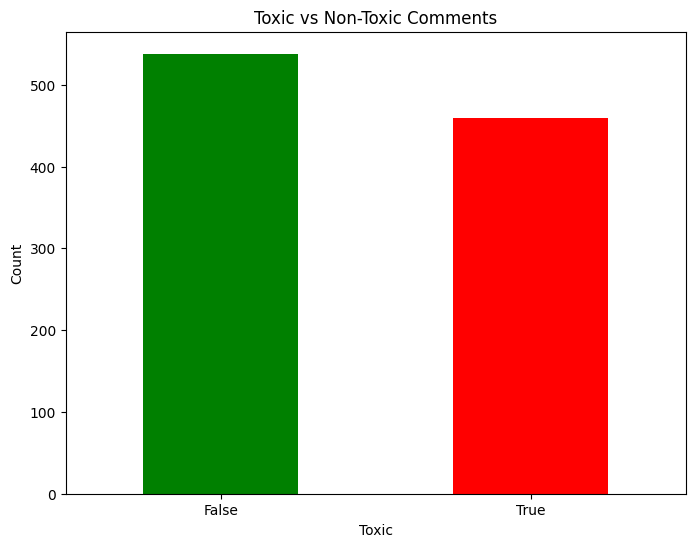

In [23]:
plt.figure(figsize=(8, 6))
toxic_counts = df2_processed['Toxic'].value_counts()
toxic_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Toxic vs Non-Toxic Comments')
plt.xlabel('Toxic')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline


In [26]:
!pip install wordcloud


In [34]:
from wordcloud import WordCloud


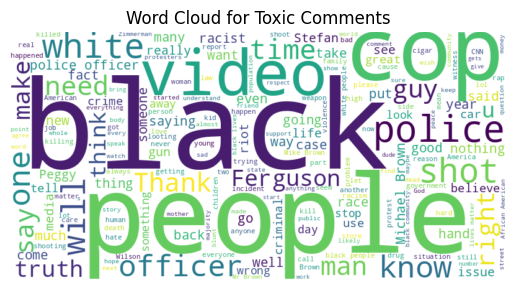

In [32]:
toxic_comments = ' '.join(df2_processed[~df2_processed['Toxic']]['Text'])
wordcloud_toxic = WordCloud(width=800, height=400, background_color='white').generate(toxic_comments)
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Toxic Comments')
plt.show()

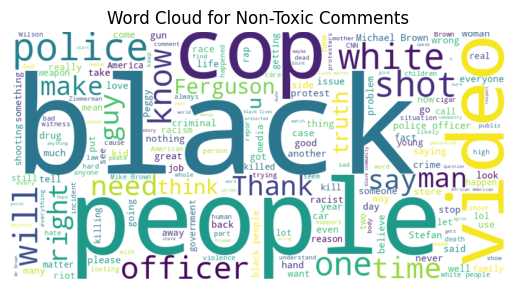

In [33]:
non_toxic_comments = ' '.join(df2_processed[~df2_processed['Toxic']]['Text'])
wordcloud_non_toxic = WordCloud(width=800, height=400, background_color='white').generate(non_toxic_comments)
plt.imshow(wordcloud_non_toxic, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Non-Toxic Comments')
plt.show()

In [35]:
df2_processed['Toxic'] = df2_processed['Toxic'].astype(int)

<ipython-input-35-c48859e548b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_processed['Toxic'] = df2_processed['Toxic'].astype(int)


In [38]:
import re  # Add this import statement

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip(' ')
    return text

# Example usage
sample_text = "What's going on? I can't believe it's happening!"
cleaned_text = clean_text(sample_text)
print(cleaned_text)


what is going on i cannot believe it happening


In [39]:
df2_processed['Text'] = df2_processed['Text'].map(lambda com : clean_text(com))

<ipython-input-39-de9e154975b4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_processed['Text'] = df2_processed['Text'].map(lambda com : clean_text(com))


In [40]:
df2_processed

,Text,Toxic
0,if only people would just take a step back and...,0
1,law enforcement is not trained to shoot to app...,1
2,dont you reckon them black lives matter banner...,1
3,there are a very large number of people who do...,0
4,the arab dude is absolutely right he should ha...,0
...,...,...
992,i remember that they sent in the national defe...,0
993,stats don t represent the problem race baiting...,1
994,the quote from the mother wow that hit hard ve...,0
995,this video is so racist,0


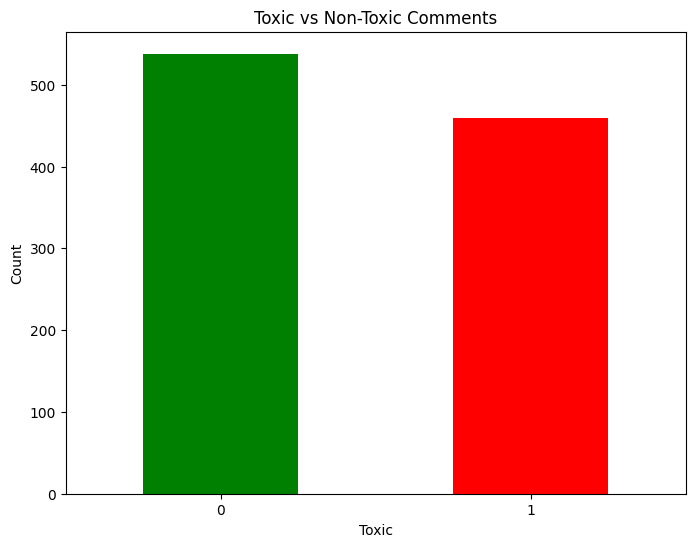

In [42]:
plt.figure(figsize=(8, 6))
toxic_counts = df2_processed['Toxic'].value_counts()
toxic_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Toxic vs Non-Toxic Comments')
plt.xlabel('Toxic')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [45]:
vect = TfidfVectorizer(max_features=5000, stop_words='english')
X = vect.fit_transform(df2_processed['Text'])
Y = df2_processed['Toxic']

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [46]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE()

# Apply SMOTE for oversampling
X_resampled, y_resampled = smote.fit_resample(X, Y)

In [47]:
df2_processed_resampled = pd.DataFrame(X_resampled.todense(), columns=vect.get_feature_names_out())
df2_processed_resampled['Toxic'] = y_resampled

# Check the distribution after oversampling
toxic_distribution_after = df2_processed_resampled['Toxic'].value_counts()
print("\nDistribution after SMOTE:")
print(toxic_distribution_after)


Distribution after SMOTE:
Toxic
0    538
1    538
Name: count, dtype: int64


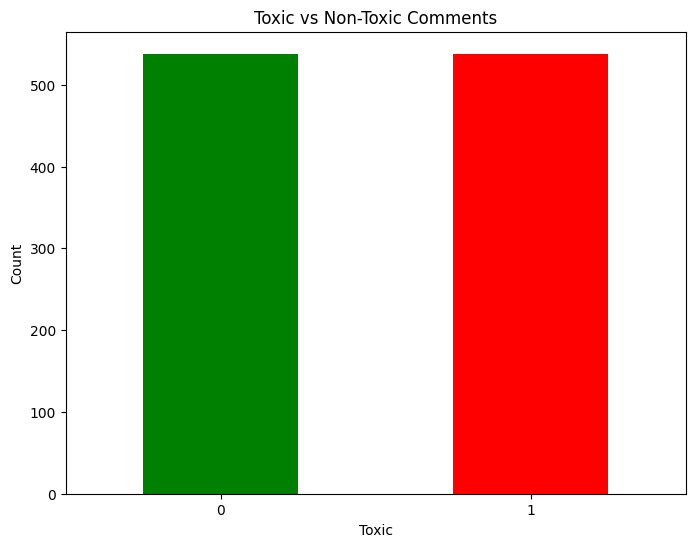

In [49]:
plt.figure(figsize=(8, 6))
toxic_counts = df2_processed_resampled['Toxic'].value_counts()
toxic_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Toxic vs Non-Toxic Comments')
plt.xlabel('Toxic')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [50]:
x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [59]:
model = Sequential([
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [52]:
from tensorflow.keras.models import Sequential


In [54]:
from tensorflow.keras.layers import Dense


In [56]:
from tensorflow.keras.layers import Dropout


In [58]:
from tensorflow.keras.optimizers import Adam


In [60]:
history = model.fit(x_train.toarray(), y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.5397 - loss: 0.6922 - val_accuracy: 0.5523 - val_loss: 0.6915
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7505 - loss: 0.6761 - val_accuracy: 0.5988 - val_loss: 0.6863
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8533 - loss: 0.6526 - val_accuracy: 0.6860 - val_loss: 0.6765
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9003 - loss: 0.6193 - val_accuracy: 0.6570 - val_loss: 0.6631
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9487 - loss: 0.5568 - val_accuracy: 0.6628 - val_loss: 0.6465


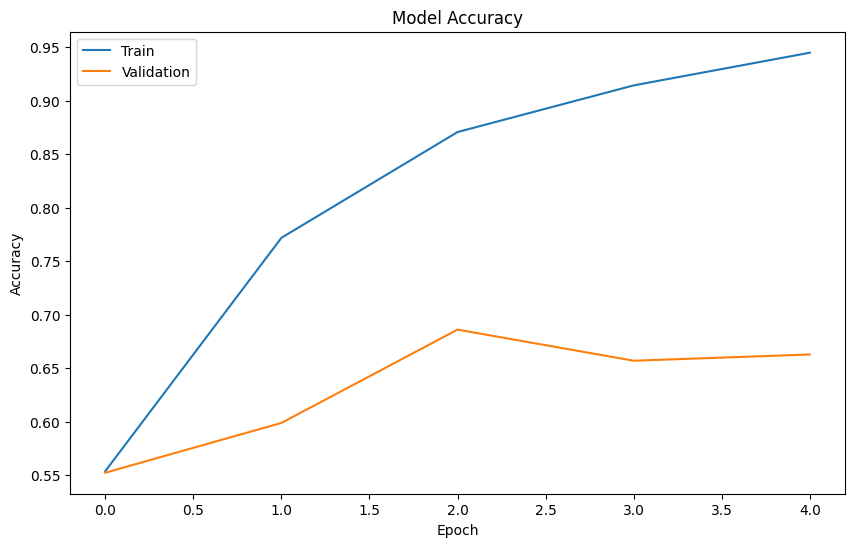

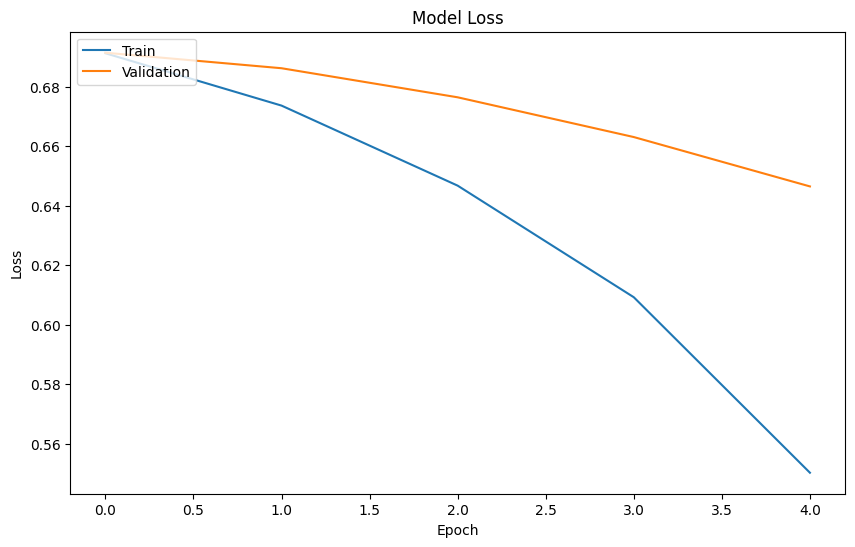

In [61]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [62]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step - accuracy: 0.6890 - loss: 0.6379
Test Accuracy: 0.6990740895271301


In [63]:
from sklearn.metrics import classification_report

# Generate predictions on the test set
y_pred_proba = model.predict(x_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Generate classification report
report = classification_report(y_test, y_pred)
print(report)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step
              precision    recall  f1-score   support

           0       0.61      0.82      0.70        93
           1       0.82      0.61      0.70       123

    accuracy                           0.70       216
   macro avg       0.71      0.71      0.70       216
weighted avg       0.73      0.70      0.70       216



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


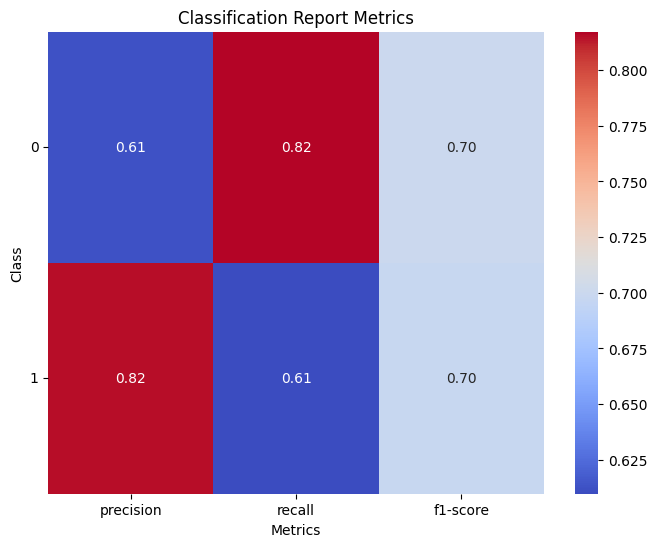

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Generate predictions on the test set
y_pred_proba = model.predict(x_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Extract relevant metrics for visualization
class_metrics = df_report.drop(['accuracy', 'macro avg', 'weighted avg'])
plt.figure(figsize=(8, 6))
sns.heatmap(class_metrics[['precision', 'recall', 'f1-score']], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Classification Report Metrics')
plt.xlabel('Metrics')
plt.ylabel('Class')
plt.yticks(rotation=0)
plt.show()